In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getEPPA(ell, ndays, case):
    fldStr = {'orig': '',
               'crseAtm':'_crseAtm',
               'Recipe':'_Recipe'
                }
    
    fileStr = {'orig': '',
               'crseAtm':'_crseAtmP5deg',
               'Recipe':'_RecipeP5deg'
                }
    
    fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/run/output{0:s}/{1:d}km/1to200/'.format(fldStr[case], ell)
    EPPA = np.zeros((ndays, 434, 1120), dtype=float)
    for day in range(ndays):
        fileName = 'ROMS_withWRF_data{2:s}_filteredAt_{0:04d}_timeAt{1:03d}.nc'.format(ell, day, fileStr[case])
        ds = Dataset(fldLoc + fileName)
        ut = np.array(ds.variables['tauxUo'])
        vt = np.array(ds.variables['tauyVo'])
        uo = np.array(ds.variables['uo'])
        vo = np.array(ds.variables['vo'])
        tx = np.array(ds.variables['taux'])
        ty = np.array(ds.variables['tauy'])
        EPPA[day,:,:] = (ut - tx*uo) +(vt - ty*vo)
    return EPPA

In [3]:
gridDS = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/input/ROMSgrid.nc')
UAREA = np.array(gridDS.variables['UAREA'])
gridDS.variables.keys()

kmtDS = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/ROMSandWRF/MakeData_Instantaneous_origInputData_CoarseAtm2deg_withRecipe/KMT_ROMSnWRF.nc')
kmt = np.array(kmtDS.variables['KMT'][:,:], dtype=float)

In [4]:
mask = np.zeros(UAREA.shape, dtype=float)
mask[70:-70,70:-70] = 1

In [5]:
ellList = [10, 20, 50, 80, 100, 200, 300, 500, 800]
ndays = 100
nell = len(ellList)

EPPA = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_crseAtm = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_Recipe = np.zeros((nell, ndays, 434, 1120), dtype=float)

In [6]:
for i in range(nell):
    EPPA[i,:,:,:] = getEPPA(ellList[i], ndays, 'orig')
    EPPA_crseAtm[i,:,:,:] = getEPPA(ellList[i], ndays, 'crseAtm')
    EPPA_Recipe[i,:,:,:] = getEPPA(ellList[i], ndays, 'Recipe')

In [7]:
fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/Downloaded/'
oGrdDs = Dataset(fldLoc + 'roms-natl1-grid_nolake.nc')
lon_u = np.array(oGrdDs.variables['lon_rho'])-360
lat_u = np.array(oGrdDs.variables['lat_rho'])
lat = np.linspace(np.min(lat_u), np.max(lat_u), 434)
lon = np.linspace(np.min(lon_u), np.max(lon_u), 1120)

In [8]:
ratio = EPPA/EPPA_Recipe
avgRatio = np.nanmean(ratio, axis=1)
stdRatio = np.nanstd(ratio, axis=1)

/tmp/ipykernel_1298075/766158713.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = EPPA/EPPA_Recipe
/tmp/ipykernel_1298075/766158713.py:2: RuntimeWarning: Mean of empty slice
  avgRatio = np.nanmean(ratio, axis=1)
/global/homes/s/srai/.conda/envs/mpiNetCDF/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


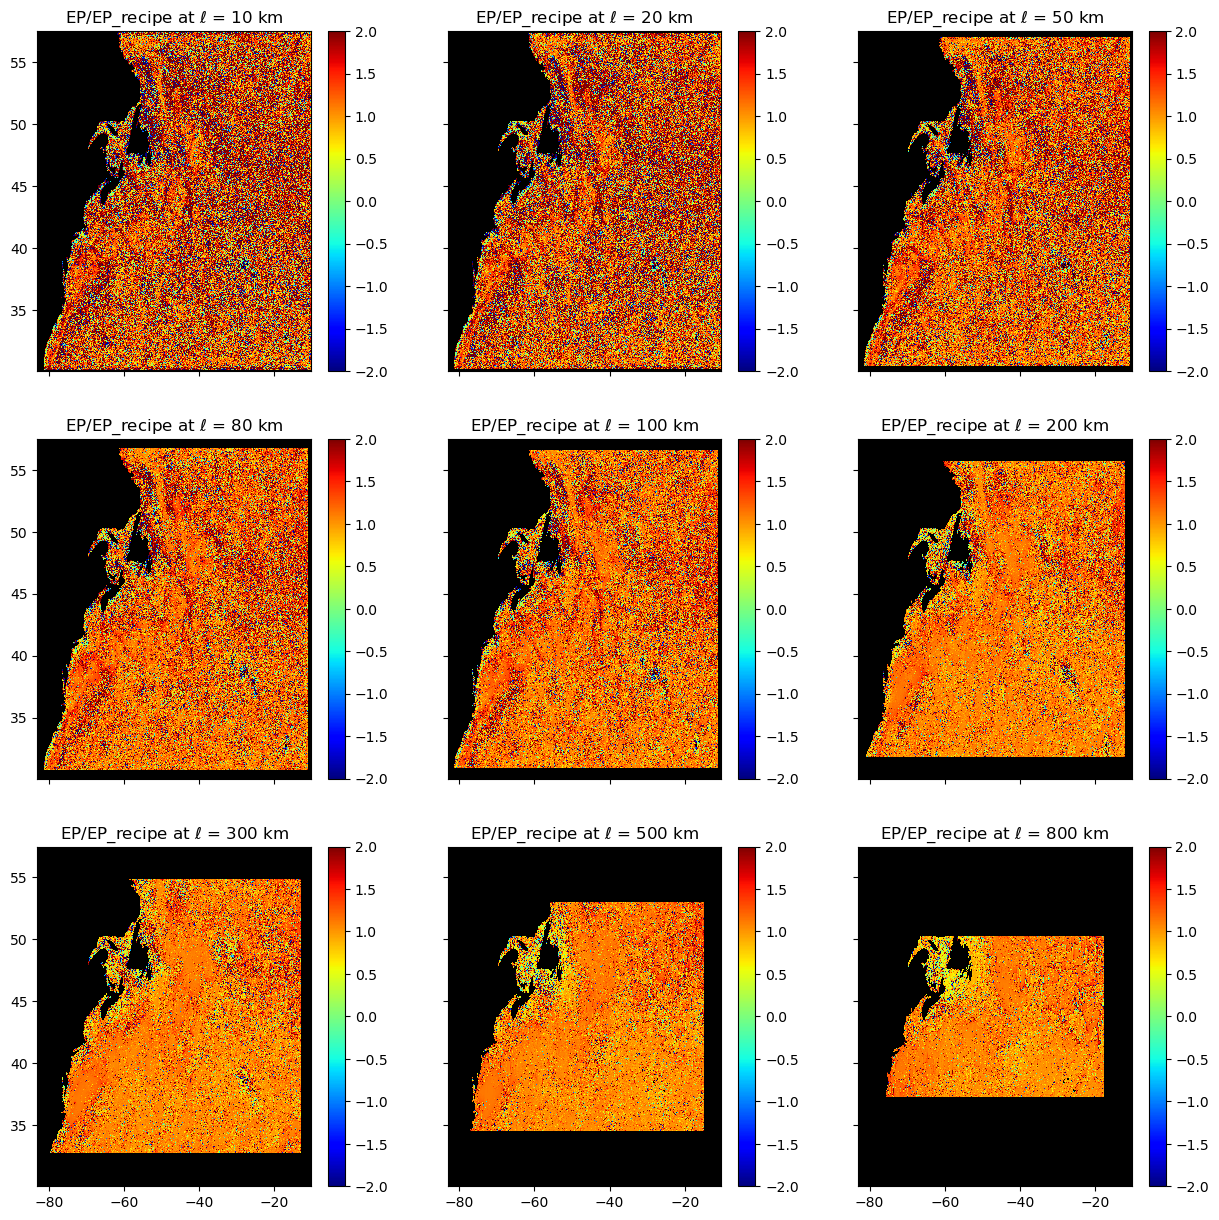

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey= True, figsize = (15,15))
c = 0
v=2
cmap = plt.get_cmap('jet').copy()
cmap.set_bad('k')
for i in range(3):
    for j in range(3):
        mskIdx = int((ellList[c]//7))
        pltArr = avgRatio[c, :, :].copy()
        pltArr[kmt<1] = float('nan')
        pltArr[pltArr == 0] = float('nan')
        pltArr[0:mskIdx,:] = float('nan')
        pltArr[:,0:mskIdx] = float('nan')
        pltArr[434-mskIdx:434,:] = float('nan')
        pltArr[:,1120-mskIdx:1120] = float('nan')
        ax = axes[i,j]
        pmesh = ax.pcolormesh(lon, lat, pltArr, cmap=cmap, vmin=-v, vmax=v, rasterized=True)
        ax.set_title(r'EP/EP_recipe at $\ell$ = {0:d} km'.format(ellList[c]))
        clb = plt.colorbar(pmesh, ax=ax)
        #clb.ax.set_title(r'$mWatts/m^2$')
        c += 1

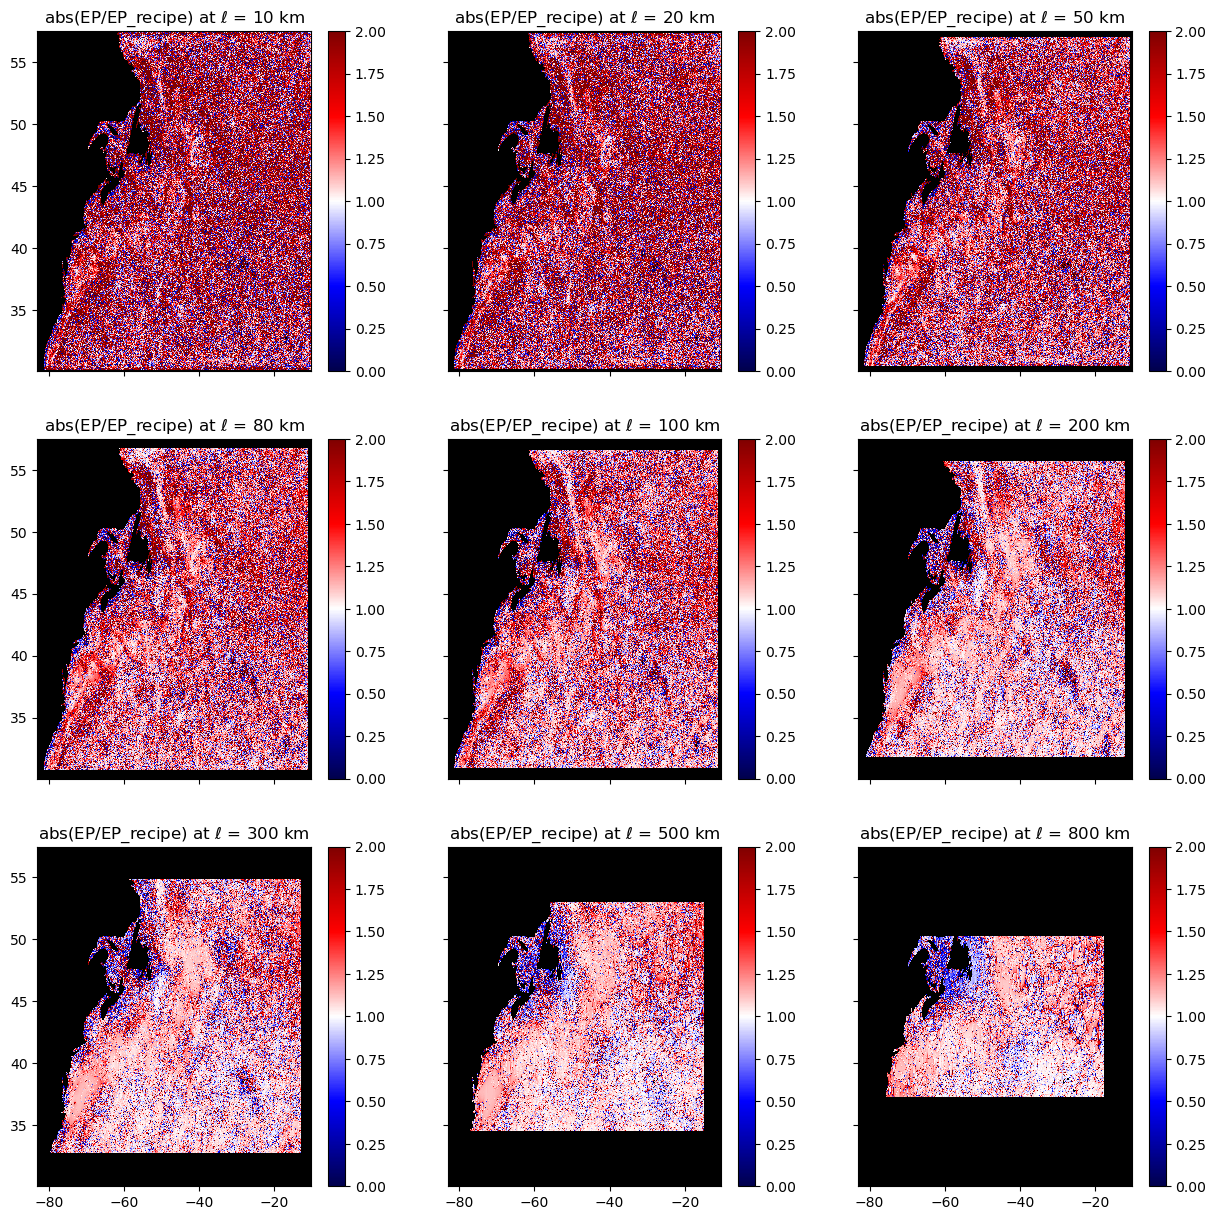

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey= True, figsize = (15,15))
c = 0
#v=2
cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')
for i in range(3):
    for j in range(3):
        mskIdx = int((ellList[c]//7))
        pltArr = abs(avgRatio[c, :, :].copy())
        pltArr[kmt<1] = float('nan')
        pltArr[pltArr == 0] = float('nan')
        pltArr[0:mskIdx,:] = float('nan')
        pltArr[:,0:mskIdx] = float('nan')
        pltArr[434-mskIdx:434,:] = float('nan')
        pltArr[:,1120-mskIdx:1120] = float('nan')
        ax = axes[i,j]
        pmesh = ax.pcolormesh(lon, lat, pltArr, cmap=cmap, vmin=0, vmax=2, rasterized=True)
        ax.set_title(r'abs(EP/EP_recipe) at $\ell$ = {0:d} km'.format(ellList[c]))
        clb = plt.colorbar(pmesh, ax=ax)
        #clb.ax.set_title(r'$mWatts/m^2$')
        c += 1

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey= True, figsize = (15,15))
c = 0
#v=2
cmap = plt.get_cmap('jet').copy()
cmap.set_bad('k')
for i in range(3):
    for j in range(3):
        mskIdx = int((ellList[c]//7))
        pltArr = abs(stdRatio[c, :, :].copy())
        pltArr[kmt<1] = float('nan')
        pltArr[pltArr == 0] = float('nan')
        pltArr[0:mskIdx,:] = float('nan')
        pltArr[:,0:mskIdx] = float('nan')
        pltArr[434-mskIdx:434,:] = float('nan')
        pltArr[:,1120-mskIdx:1120] = float('nan')
        ax = axes[i,j]
        pmesh = ax.pcolormesh(lon, lat, pltArr, cmap=cmap, vmin=0, vmax=5, rasterized=True)
        ax.set_title(r'std dev of EP/EP_recipe at $\ell$ = {0:d} km'.format(ellList[c]))
        clb = plt.colorbar(pmesh, ax=ax)
        #clb.ax.set_title(r'$mWatts/m^2$')
        c += 1